In [2]:
#import and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


## Load Data


In [5]:
sentiment = pd.read_csv("C:\\Users\\mohan\\Downloads\\fear_greed_index.csv")
trader = pd.read_csv("C:\\Users\\mohan\\Downloads\\historical_data.csv")

print("Sentiment Shape:", sentiment.shape)
print("Trader Shape:", trader.shape)


Sentiment Shape: (2644, 4)
Trader Shape: (211224, 16)


##  Initial Data Audit

In [6]:
print("---- Sentiment Missing Values ----")
print(sentiment.isnull().sum())

print("\n---- Trader Missing Values ----")
print(trader.isnull().sum())

print("\nTrader Duplicates:", trader.duplicated().sum())


---- Sentiment Missing Values ----
timestamp         0
value             0
classification    0
date              0
dtype: int64

---- Trader Missing Values ----
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Trader Duplicates: 0


In [7]:
trader = trader.drop_duplicates()


## Date Processing & Alignment

In [8]:
# Convert sentiment date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Simplify classification
sentiment['sentiment_group'] = sentiment['classification'].apply(
    lambda x: "Fear" if "Fear" in x else "Greed"
)

sentiment = sentiment[['date', 'sentiment_group']]

# Convert trader timestamp (epoch ms → datetime)
trader['date'] = pd.to_datetime(trader['Timestamp'], unit='ms').dt.date


In [9]:
merged = trader.merge(sentiment, on='date', how='inner')

print("Merged Shape:", merged.shape)


Merged Shape: (184263, 18)


## Feature Engineering

In [10]:
merged['win'] = merged['Closed PnL'] > 0
merged['abs_size'] = merged['Size USD'].abs()
merged['is_long'] = merged['Side'] == 'Long'


## Daily Trader-Level Metrics

In [13]:
daily_trader = merged.groupby(['Account', 'date', 'sentiment_group']).agg(
    daily_pnl=('Closed PnL', 'sum'),
    trades_per_day=('Closed PnL', 'count'),
    win_rate=('win', 'mean'),
    avg_trade_size=('abs_size', 'mean'),
    long_ratio=('is_long', 'mean')
).reset_index()

daily_trader.head()


,Account,date,sentiment_group,daily_pnl,trades_per_day,win_rate,avg_trade_size,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,462,0.025974,14810.891818,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,3356,0.405542,16345.241940,0.0
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,320,0.531250,2492.749906,0.0
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,3533,0.435041,1693.351684,0.0
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Greed,-1.000000e+00,5,0.000000,6070.200000,0.0


## Drawdown Proxy

In [14]:
daily_trader = daily_trader.sort_values(['Account', 'date'])

daily_trader['rolling_max'] = daily_trader.groupby('Account')['daily_pnl'].cummax()
daily_trader['drawdown'] = daily_trader['daily_pnl'] - daily_trader['rolling_max']


## Sentiment Comparison

In [15]:
sentiment_analysis = daily_trader.groupby('sentiment_group').agg(
    mean_pnl=('daily_pnl', 'mean'),
    median_pnl=('daily_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_trades=('trades_per_day', 'mean'),
    avg_trade_size=('avg_trade_size', 'mean'),
    avg_long_ratio=('long_ratio', 'mean'),
    avg_drawdown=('drawdown', 'mean')
).reset_index()

print(sentiment_analysis)


  sentiment_group       mean_pnl    median_pnl  avg_win_rate   avg_trades  \
0            Fear  209372.662205  81389.682515      0.415878  4183.468750   
1           Greed   78340.542338  16102.568590      0.349753  1119.822222   

   avg_trade_size  avg_long_ratio  avg_drawdown  
0     5926.522723             0.0 -69483.517281  
1     5309.505414             0.0  -8039.860561  


## High Vs Low Trade Size Traders

In [16]:
size_threshold = daily_trader['avg_trade_size'].median()

daily_trader['size_segment'] = np.where(
    daily_trader['avg_trade_size'] >= size_threshold,
    "Large Position",
    "Small Position"
)

size_segment_analysis = daily_trader.groupby(
    ['size_segment', 'sentiment_group']
).agg(
    mean_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean')
).reset_index()

print(size_segment_analysis)


     size_segment sentiment_group       mean_pnl  avg_win_rate
0  Large Position            Fear  284460.190407      0.404955
1  Large Position           Greed   28768.379884      0.338141
2  Small Position            Fear  112831.554518      0.429923
3  Small Position           Greed  121716.184486      0.359914


## frequent Vs Infrequent traders

In [19]:
trade_threshold = daily_trader['trades_per_day'].median()

daily_trader['activity_segment'] = np.where(
    daily_trader['trades_per_day'] >= trade_threshold,
    "Frequent",
    "Infrequent"
)


In [20]:
# Activity Segment Analysis
activity_segment_analysis = daily_trader.groupby(
    ['activity_segment', 'sentiment_group']
).agg(
    mean_pnl=('daily_pnl', 'mean'),
    avg_win_rate=('win_rate', 'mean')
).reset_index()

print(activity_segment_analysis)


  activity_segment sentiment_group       mean_pnl  avg_win_rate
0         Frequent            Fear  265107.235726      0.417112
1         Frequent           Greed  187022.621059      0.431317
2       Infrequent            Fear   42168.941645      0.412178
3       Infrequent           Greed   23999.502978      0.308971


## Consistent vs Volatile Traders

In [18]:
volatility = daily_trader.groupby('Account')['daily_pnl'].std().reset_index()

vol_threshold = volatility['daily_pnl'].median()

volatility['consistency_segment'] = np.where(
    volatility['daily_pnl'] <= vol_threshold,
    "Consistent",
    "Volatile"
)

daily_trader = daily_trader.merge(
    volatility[['Account', 'consistency_segment']],
    on='Account'
)


## Clustering Traders

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_features = daily_trader.groupby('Account').agg(
    avg_pnl=('daily_pnl', 'mean'),
    avg_trades=('trades_per_day', 'mean'),
    avg_win_rate=('win_rate', 'mean'),
    avg_size=('avg_trade_size', 'mean')
).reset_index()

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_features.drop('Account', axis=1))

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(scaled)

cluster_features.head()


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Account,avg_pnl,avg_trades,avg_win_rate,avg_size,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,-327505.900056,462.0,0.025974,14810.891818,2
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,20607.446093,320.0,0.531250,2492.749906,0
2,0x271b280974205ca63b716753467d5a371de622ab,896.080107,5.0,0.400000,19005.930000,2
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,121880.386016,6472.0,0.443758,483.590114,0
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52215.729448,763.0,0.474443,2941.825688,0


## Cluster Visualization Using PCA

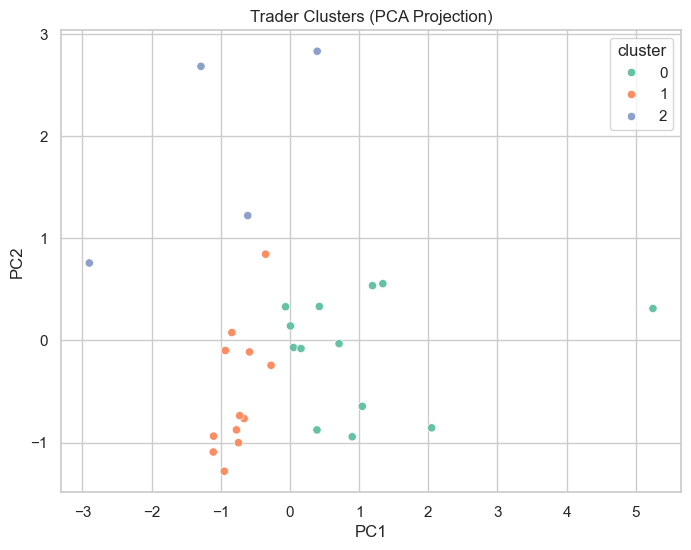

In [23]:
from sklearn.decomposition import PCA

# Apply PCA to scaled features
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled)

cluster_features['PC1'] = pca_components[:, 0]
cluster_features['PC2'] = pca_components[:, 1]

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=cluster_features,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2'
)

plt.title("Trader Clusters (PCA Projection)")
plt.show()
